# Text Preprocessing

D2L 8.2 and 8.3

We have reviewed and evaluated statistical tools and prediction
challenges for sequence data. Such data can take many forms.
Specifically, as we will focus on in many chapters of the book, text is
one of the most popular examples of sequence data. For example, an
article can be simply viewed as a sequence of words, or even a sequence
of characters. To facilitate our future experiments with sequence data,
we will dedicate this section to explain common preprocessing steps for
text. Usually, these steps are:

Load text as strings into memory.
Split strings into tokens (e.g., words and characters).
Build a table of vocabulary to map the split tokens to numerical
indices.
Convert text into sequences of numerical indices so they can be
manipulated by models easily.

In [1]:
import collections
import re
import torch
import matplotlib.pyplot as plt
import random

The following tokenize function takes a list (lines) as the input, where each element is a text sequence (e.g., a text line). Each text sequence is split into a list of tokens. A token is the basic unit in text. In the end, a list of token lists are returned, where each token is a string.

In [2]:
import requests
import os
import hashlib

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def download(url, folder='./data', sha1_hash=None):
    """Download a file to folder and return the local filepath.
    Defined in :numref:`sec_utils`"""
    if not url.startswith('http'):
        # For back compatability
        url, sha1_hash = DATA_HUB[url]
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, url.split('/')[-1]) # File naming as last chunk of the URL
    # Check if hit cache
    if os.path.exists(fname) and sha1_hash: # Check path validity and presence of hash (no hash in this case)
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    # Download
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname 


def read_time_machine():  #@save
    """Load the time machine dataset into a list of text lines."""
    # Downloads text file from from site hosted on AWS.
    with open(download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [3]:
def tokenize(lines, token='word'):  
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [4]:
class Vocab:  
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs

def count_corpus(tokens):  #@save
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [5]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [6]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [7]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## Summary

Text is an important form of sequence data.

To preprocess text, we usually split text into tokens, build a vocabulary to map token strings into numerical indices, and convert text data into token indices for models to manipulate.

## Exercises
1. Tokenization is a key preprocessing step. It varies for different languages. Try to find another three commonly used methods to tokenize text.
   
   **A**: The main focus was on White space tokenisation (words) and character tokenisation.
   * Punctuation and white space tokeniser
   * Treebank with contractions tokeniser
   * Multi-word expression tokeniser that combines words into phrases e.g. James Bond into James_Bond.
   * SpaCy
   * For languages without white space, for example Cantonese, use a segmentation algorithm first. 

2. In the experiment of this section, tokenize text into words and vary the min_freq arguments of the Vocab instance. How does this affect the vocabulary size?

   **A**: The `min_freq` argument is some sort of filter.

# Language Models and the Dataset

In [8]:
tokens = tokenize(read_time_machine())
# Since each text line is not necessarily a sentence or a paragraph, we
# concatenate all text lines
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

As we can see, the most popular words are actually quite boring to look at. They are often referred to as stop words and thus filtered out. Nonetheless, they still carry meaning and we will still use them. Besides, it is quite clear that the word frequency decays rather rapidly. The  most frequent word is less than  as common as the most popular one. To get a better idea, we plot the figure of the word frequency.

Text(0, 0.5, 'frequency: n(x)')

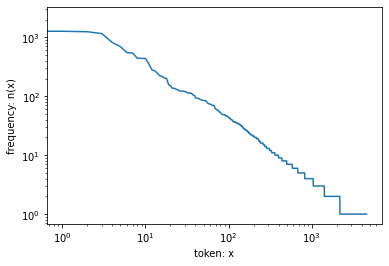

In [9]:
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')

In [10]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [11]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

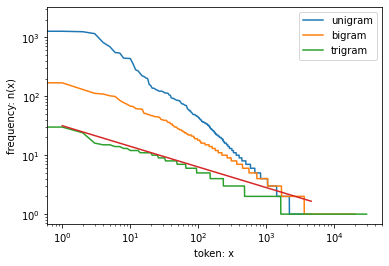

In [12]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plt.plot(freqs, label='unigram')
plt.plot(bigram_freqs, label='bigram')
plt.plot(trigram_freqs, label='trigram')

# This is trial and error to find the exponent
def zipf(i, a, c):
    n = c / i**(a)
    return n

xrange = torch.arange(0, len(freqs))
plt.plot(zipf(xrange, 0.35, 10**1.5))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('token: x')
plt.ylabel('frequency: n(x)')
plt.legend()

The following demonstrates the difference between random sampling and sequential sampling.

In [20]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch (subset of data) of subsequences using random sampling.

    In random sampling, the subsequences from two adjacent random
    minibatches during iteration are not necessarily adjacent on the
    original sequence
    
    Args:
        corpus (list): words in an iterable
        batch_size (int): Minibatch size, number of sample sequences to take
        num_steps (int): number of steps/ tokens in each sample sequence
    
    Returns:
        X (tensor): features
        Y (tensor): labels

    """
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    
    # Modify order for random shuffling
    random.shuffle(initial_indices)
    
    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [21]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[16, 17, 18, 19, 20],
        [11, 12, 13, 14, 15]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16]])
X:  tensor([[26, 27, 28, 29, 30],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [ 7,  8,  9, 10, 11]])
X:  tensor([[ 1,  2,  3,  4,  5],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [22, 23, 24, 25, 26]])


In [22]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [23]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


In [24]:
class SeqDataLoader:  
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [25]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## Exercises
1. Suppose there are  words in the training dataset. How much word frequency and multi-word adjacent frequency does a four-gram need to store?
   
   **A**: Suppose there are N words in the training dataset. The maximum word frequency would be $N/4$, assuming the four-gram is repeating in the training dataset. Assuming the words are all distinct, there will be $N \choose 4$ different four-grams which need to be taken into account of.

2. How would you model a dialogue?
   
   **A**: You would need two distinct corpuses, one for each interlocutor. The input for person B is the output for person A. 

3. Estimate the exponent of Zipf’s law for unigrams, bigrams, and trigrams.
   
   **A**: Unigrams $(\alpha = 1)$, Bigrams $(\alpha = 0.65)$, Trigrams $(\alpha = 0.35)$. This was done by eye by plotting a curve with variable constants. Decreasing, as expected. Rate of decrease slows.

4. What other methods can you think of for reading long sequence data?
   **A**: You can split by syllable, or sub-word, for commonly occuring substrings (fast.ai).

6. Consider the random offset that we use for reading long sequences.
   1. Why is it a good idea to have a random offset?
   
      **A**: So when the split gets run again, it will produce different tokens. Gives good coverage.

   2. Does it really lead to a perfectly uniform distribution over the sequences on the document?

      **A**: If you are splitting from text, some combinations would occur more than others. Depending on what you mean by 'random,' this may or may not be the desired effect.

   3. What would you have to do to make things even more uniform?
   
      **A**: You can vary the length of the chunk, or use an even longer sequence.

7. If we want a sequence example to be a complete sentence, what kind of problem does this introduce in minibatch sampling? How can we fix the problem?
   
   **A**: As sentences typically have different lengths (in terms of number of words/ characters), it would be difficult to build a model out of it. Perhaps you could force the sequence to end on a full-stop when training?